# Восстановление золота из руды

<b> Цель проекта </b>

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

<b> Описание данных </b>

*Технологический процесс*
    
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

*Параметры этапов*
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


Наименование признаков *[этап].[тип_параметра].[название_параметра]*, пример: rougher.input.feed_ag

Возможные значения для блока *[этап]*:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока *[тип_параметра]*:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики


## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv') #обучающая выборка
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv') #тестовые данные
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv') #исходные данные

In [ ]:
data_train.info()
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
data_test.info()
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


В обучающем датасете 87 столбцов, в то время как в тестовой выборке 53. Все столбцы имеют тип данных float, кроме даты с форматом object.

In [ ]:
data_train.duplicated().sum()

0

In [ ]:
data_test.duplicated().sum()

0

In [ ]:
data_full.duplicated().sum()

0

Дубликатов в данных не обнаружено.

Проверим расчет эффективности обогащения, вычислим её на обучающей выборке для признака *rougher.output.recovery*. Найдем MAE между расчётами и значением признака.

In [ ]:
c = data_train['rougher.output.concentrate_au'].fillna(0) #доля золота в концентрате после флотации/очистки
f = data_train['rougher.input.feed_au'].fillna(0) #доля золота в сырье/концентрате до флотации/очистки
t = data_train['rougher.output.tail_au'].fillna(0) #доля золота в отвальных хвостах после флотации/очистки

In [ ]:
recovery = c*(f-t)/(f*(c-t))*100

In [ ]:
recovery_target = data_train['rougher.output.recovery'].fillna(0)

In [ ]:
mae = mean_absolute_error(recovery_target,recovery)
print("Средняя абсолютная ошибка:", mae)

Средняя абсолютная ошибка: 9.682896147825551e-15


Получили значение средней абсолютной ошибки - 9.7 x 10^(-15), что является минимальным, значит эффективность обогащения рассчитана правильно.

Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?


In [ ]:
different_columns = data_train.columns.difference(data_test.columns)
print(different_columns)
print()
print("Количество отсутствующих столбцов:",len(different_columns))

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

Среди столбцов, отсутствующих в тестовой выборке можем видеть столбцы *final.output, primary_cleaner.output, rougher.calculation, rougher.output, secondary_cleaner.output*. Из них блоки output являются параметрами продукта, а calculation - расчетной характеристикой. Всего столбцов 34.

Среди отсутствующих столбцов имеются целевые признаки: *final.output.recovery и rougher.output.recovery*, поэтому восстановим их из датасета *data_full* с помощью общего столбца *date*.

In [ ]:
data_test = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']],
                            on='date', how='left')

Так как данные индексируются датой и временем получения информации, и соседние по времени параметры часто похожи, заполним пропуски методом ffill, который использует для этого предыдущее значение в столбце.

In [ ]:
data_test=data_test.ffill(axis=0)
data_train=data_train.ffill(axis=0)
data_full=data_full.ffill(axis=0)

In [ ]:
data_test.shape

(5290, 55)

<b>Вывод</b>

В данном шаге были изучены файлы, проведена предобработка данных:
- дубликаты были не обнаружены;
- пропущенные значения заменены методом ffill;
- в тестовую выборку были добавлены целевые признаки;
- из обучающей выборки были удалены признаки, которых нет в тестовой;
- был проверен расчет эффективности обогащения.

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Для лучшей репрезентации построим графики.

Text(0.5, 1.0, 'Концентрация золота на различных этапах очистки')

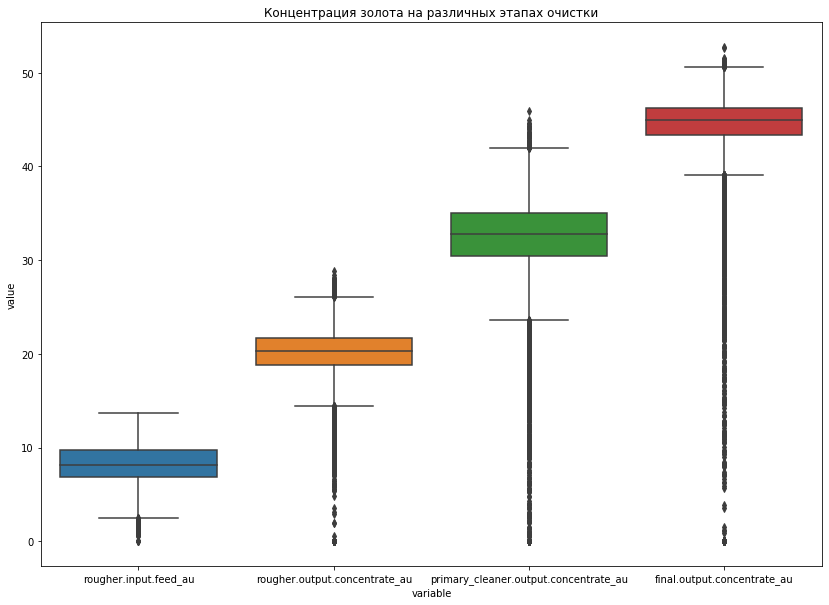

In [ ]:
df = pd.DataFrame(data = data_full, columns = ['rougher.input.feed_au','rougher.output.concentrate_au',
                     'primary_cleaner.output.concentrate_au','final.output.concentrate_au'])

plt.figure(figsize=(14,10))
sns.boxplot(x="variable", y="value", data=pd.melt(df)).set_title('Концентрация золота на различных этапах очистки')

Text(0.5, 1.0, 'Концентрация серебра на различных этапах очистки')

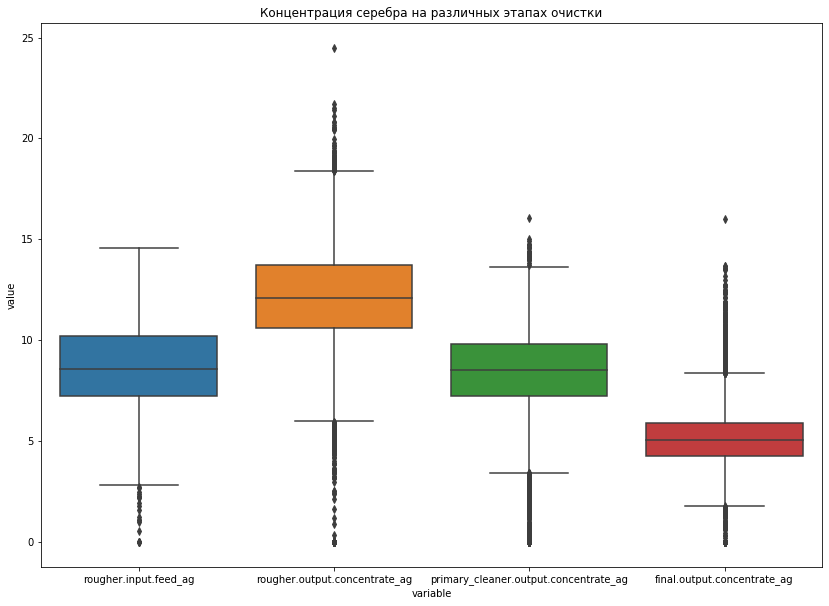

In [ ]:
df = pd.DataFrame(data = data_full, columns = ['rougher.input.feed_ag','rougher.output.concentrate_ag',
                     'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag'])

plt.figure(figsize=(14,10))
sns.boxplot(x="variable", y="value", data=pd.melt(df)).set_title('Концентрация серебра на различных этапах очистки')

Text(0.5, 1.0, 'Концентрация свинца на различных этапах очистки')

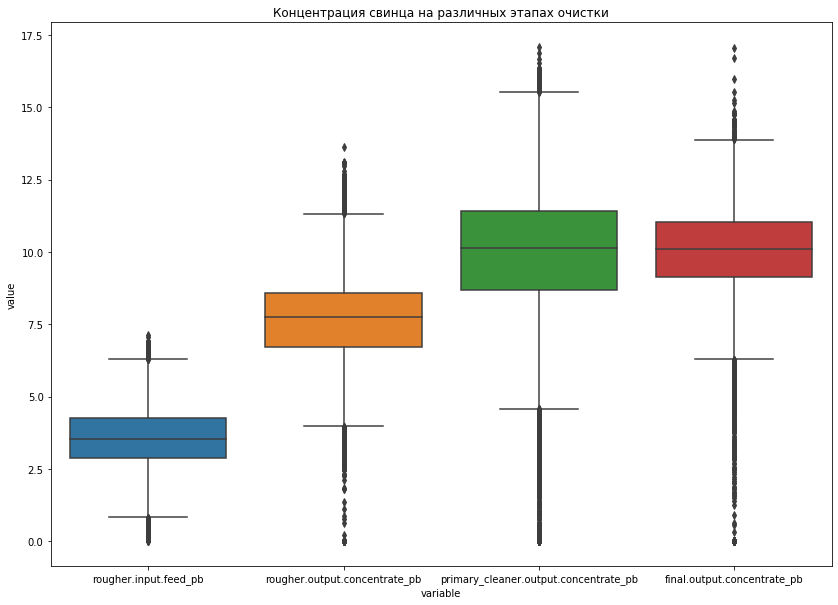

In [ ]:
df = pd.DataFrame(data = data_full, columns = ['rougher.input.feed_pb','rougher.output.concentrate_pb',
                     'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb'])

plt.figure(figsize=(14,10))
sns.boxplot(x="variable", y="value", data=pd.melt(df)).set_title('Концентрация свинца на различных этапах очистки')

Исходя из графиков, видим, что концентрация золота возрастает на каждом этапе очистки. В то время как концентрация серебра максимальна в черновом концентрате после флотации и уменьшается с последующими этапами очистки. Концентрация свинца увеличивается, после первого этапа немного возросла медиана и уменьшился разброс значений. 

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

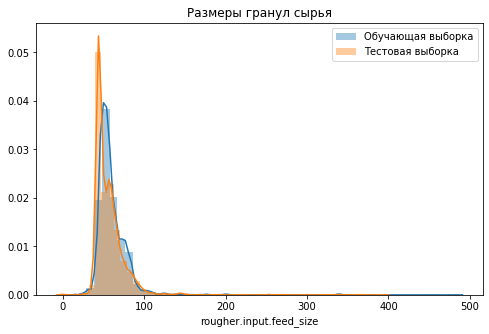

In [ ]:
plt.figure(figsize=(8,5))

sns.distplot(data_train['rougher.input.feed_size'], label='Обучающая выборка').set_title('Размеры гранул сырья')
sns.distplot(data_test['rougher.input.feed_size'], label='Тестовая выборка')
plt.legend()

In [ ]:
data_train['rougher.input.feed_size'].mean()

60.23985599255732

In [ ]:
data_test['rougher.input.feed_size'].mean()

55.95275402889513

Исходя из графиков и полученных средних значений, видим, что размеры гранул сырья на обучающей и тестовой выборках отличаются немного, но не сильно.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

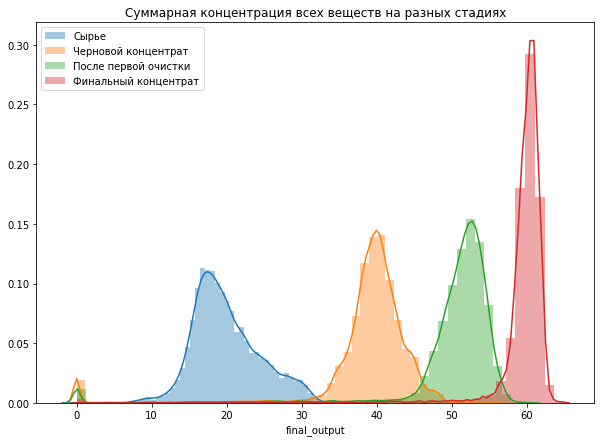

In [ ]:
total = pd.DataFrame()


total['rougher_input'] = data_train['rougher.input.feed_au']+data_train[
    'rougher.input.feed_ag']+data_train['rougher.input.feed_pb']

total['rougher_output'] = data_train['rougher.output.concentrate_au']+data_train[
    'rougher.output.concentrate_ag']+data_train['rougher.output.concentrate_pb']

total['primary_output'] = data_train['primary_cleaner.output.concentrate_au']+data_train[
    'primary_cleaner.output.concentrate_ag']+data_train['primary_cleaner.output.concentrate_pb']

total['final_output'] = data_train['final.output.concentrate_au']+data_train[
    'final.output.concentrate_ag']+data_train['final.output.concentrate_pb']


plt.figure(figsize=(10,7))


sns.distplot(total['rougher_input'], label='Сырье').set_title('Суммарная концентрация всех веществ на разных стадиях')
sns.distplot(total['rougher_output'], label='Черновой концентрат')
sns.distplot(total['primary_output'], label='После первой очистки')
sns.distplot(total['final_output'], label='Финальный концентрат')


plt.legend()

На графике суммарной концентрации видим значения 0. В суммарной руде общее значение, равное 0, невозможно, так как минимум одно из веществ присутствовать должно. Поэтому удалим из тренировочной выборки строки, где каждая из концентраций металлов равна 0.

In [ ]:
data_train = data_train[(data_train['rougher.input.feed_au'] > 0) & (
    data_train['rougher.input.feed_ag'] > 0) & (data_train['rougher.input.feed_pb'] > 0)]

data_train = data_train[(data_train['rougher.output.concentrate_au'] > 0) & (
    data_train['rougher.output.concentrate_ag'] > 0) & (data_train['rougher.output.concentrate_pb'] > 0)]

data_train = data_train[(data_train['primary_cleaner.output.concentrate_au'] > 0) & (
    data_train['primary_cleaner.output.concentrate_ag'] > 0) & (data_train[
    'primary_cleaner.output.concentrate_pb'] > 0)]

data_train = data_train[(data_train['final.output.concentrate_au'] > 0) & (
    data_train['final.output.concentrate_ag'] > 0) & (data_train['final.output.concentrate_pb'] > 0)]

Перейдем к построению модели.

## Модель

Напишем функцию для вычисления итоговой sMAPE.

In [ ]:
def smape(target, predictions):
    a = abs(target-predictions)
    b = (abs(target)+abs(predictions))/2
    error = a/b
    return error.sum()/error.shape[0]*100

In [ ]:
def smape_final(rougher,final):
    final_result = 0.25*rougher+0.75*final
    return final_result

Перейдем к обучению моделей. 

Удалим столбцы, которых нет в тестовой выборке, из обучающего датасета. Также удалим столбцы date и сделаем масштабирование признаков.

In [ ]:
different_columns = data_train.columns.difference(data_test.columns)
data_train.drop(different_columns, axis=1, inplace=True)

In [ ]:
data_train.shape, data_test.shape

((13720, 55), (5290, 55))

In [ ]:
data_test.drop(['date'], axis=1, inplace=True)
data_train.drop(['date'], axis=1, inplace=True)

In [ ]:
features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]
features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']]

In [ ]:
features_train.shape, features_test.shape

((13720, 52), (5290, 52))

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
features_train = scaler.transform(features_train) 
features_test = scaler.transform(features_test) 

In [ ]:
smape_score = make_scorer(smape,greater_is_better=False)

Рассмотрим модель дерева решений:

In [ ]:
model = DecisionTreeRegressor(random_state=12345)

parameters = {'max_depth': range (1,10)}

grid_rougher = GridSearchCV(model, param_grid = parameters, scoring = smape_score, cv = 5)
grid_final = GridSearchCV(model, param_grid = parameters, scoring = smape_score, cv = 5)

grid_rougher.fit(features_train,target_train['rougher.output.recovery'])
grid_final.fit(features_train,target_train['final.output.recovery'])

print(grid_rougher.best_params_)
print(grid_final.best_params_)
print("sMAPE_rougher:", grid_rougher.best_score_)
print("sMAPE_final:", grid_final.best_score_)

{'max_depth': 4}
{'max_depth': 3}
sMAPE_rougher: -7.310586361601211
sMAPE_final: -9.429629211565238


In [ ]:
smape_result = smape_final(abs(grid_rougher.best_score_),abs(grid_final.best_score_))
print("Итоговое sMAPE дерева решений:",smape_result)

Итоговое sMAPE дерева решений: 8.899868499074232


Перейдем к модели случайного леса:

In [ ]:
model = RandomForestRegressor(random_state=12345)

parameters = {'max_depth': range (1,5), 'n_estimators': range (10, 31, 10), 'min_samples_leaf': range(1,3)}

grid_rougher = GridSearchCV(model, param_grid = parameters, scoring = smape_score, cv = 5)
grid_final = GridSearchCV(model, param_grid = parameters, scoring = smape_score, cv = 5)

grid_rougher.fit(features_train,target_train['rougher.output.recovery'])
grid_final.fit(features_train,target_train['final.output.recovery'])

print(grid_rougher.best_params_)
print(grid_final.best_params_)
print("sMAPE_rougher:", grid_rougher.best_score_)
print("sMAPE_final:",grid_final.best_score_)

{'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 30}
{'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 20}
sMAPE_rougher: -6.649749879936995
sMAPE_final: -8.961573112802748


In [ ]:
smape_result = smape_final(abs(grid_rougher.best_score_), abs(grid_final.best_score_))
print("Итоговое sMAPE случайного леса:",smape_result)

Итоговое sMAPE случайного леса: 8.383617304586311


<b> Проверка лучшей модели на тестовой выборке </b>

Лучшей моделью оказалась RandomForestRegressor. Рассчитаем итоговый sMAPE.

In [ ]:
model = RandomForestRegressor(random_state=12345, max_depth=3, min_samples_leaf=2, n_estimators=30)

model.fit(features_train,target_train['rougher.output.recovery'])
predicted_test= model.predict(features_test)

rougher_score = smape(target_test['rougher.output.recovery'], predicted_test)

In [ ]:
model = RandomForestRegressor(random_state=12345, max_depth=4, min_samples_leaf=1, n_estimators=20)

model.fit(features_train,target_train['final.output.recovery'])
predicted_test= model.predict(features_test)

final_score = smape(target_test['final.output.recovery'], predicted_test)

In [ ]:
test_final_smape = smape_final(rougher_score,final_score)

print(test_final_smape)

9.603261784370023


<b>Сравним результат с константной моделью</b>

In [ ]:
dummy_rougher = DummyRegressor(strategy="mean")
dummy_final = DummyRegressor(strategy="mean")

dummy_rougher.fit(features_train,target_train['rougher.output.recovery'])
dummy_final.fit(features_train,target_train['final.output.recovery'])

dummy_r_test = dummy_rougher.predict(features_test)
dummy_f_test = dummy_final.predict(features_test)

smape_final(smape(target_test['rougher.output.recovery'],dummy_r_test), 
            smape(target_test['final.output.recovery'],dummy_f_test))

9.828785881311733

Получили прогноз по среднему 9.82, результат на модели меньше чем на константной, поэтому его можно считать приемлемым. 

## Общий вывод

В данном проекте были проанализированы и предобработы данные и построена модель, предсказывающая коэффициент восстановления золота из золотосодержащей руды. Были рассмотрены три модели: DecisionTreeRegressor и RandomForestClassifier, лучшей из них оказалась <b>RandomForestClassifier</b> с итоговым sMAPE на тестовой выборке 9.6. 